# Text to Image

In [ ]:
!pip install diffusers transformers scipy ftfy accelerate lpips

In [ ]:
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
import numpy
from torchvision import transforms as tfms


# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# since we have limited VRAM, we load the model with float16 percision instead of float32
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16)

In [ ]:
pipe.to("cuda")

In [ ]:
#text to image

prompt = "a photograph of an astronaut riding a horse"

image = pipe(prompt).images[0]

# you can save the image with
# image.save(f"astronaut_rides_horse.png")

In [ ]:
image

In [ ]:
# determenistic generation
generator = torch.Generator("cuda").manual_seed(1024)
image = pipe(prompt, guidance_scale=7.5, generator=generator).images[0]

# you can save the image with
# image.save(f"astronaut_rides_horse.png")

In [ ]:
image

In [ ]:
# changing number of steps
generator = torch.Generator("cuda").manual_seed(1024)
image = pipe(prompt, guidance_scale=7.5, num_inference_steps=15, generator=generator).images[0]

In [ ]:
image

Ho, J. and Salimans, T. (2022). Classifier-Free Diffusion Guidance. arXiv:2207.12598 [cs]. [online] Available at: https://arxiv.org/abs/2207.12598.

# Image to Image

In [ ]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
model_id_or_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id_or_path, torch_dtype=torch.float16)
pipe = pipe.to(device)

url = "https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((768, 512))

prompt = "A fantasy landscape, trending on artstation"

images = pipe(prompt=prompt, image=init_image, strength=0.75, guidance_scale=7.5).images
images[0].save("fantasy_landscape.png")

In [ ]:
init_image

# Stable Diffusion

Stable Diffusion is a latent, text-to-image diffusion model that was released in 2022. Latent diffusion models (LDMs) operate by repeatedly reducing noise in a latent representation space and then converting that representation into a complete image.

A model that combines different neural networks, the process of text-to-image generation in Stable Diffusion can be divided into four. Here’s an overview:



*   First, an Image Encoder converts training images into vectors in a mathematical space known as the latent space, where image information can be represented as arrays of numbers and have lower dimensions compared to the original input.
*   A Text Encoder translates text into high-dimensional vectors that machine learning models can comprehend.
*   A Diffusion Model then utilizes the text guidance to create new images in the latent space.
*   Finally, an Image Decoder transforms the image data from the latent space into an actual image constructed with pixels.

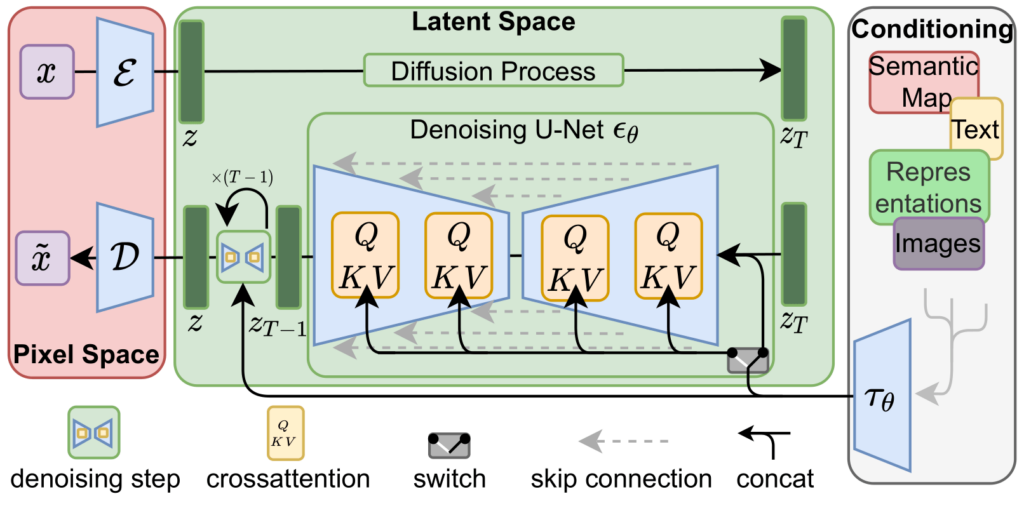

The primary function of Stable Diffusion is to generate detailed images based on text descriptions, but it can also be used for other tasks like inpainting, outpainting, and creating image-to-image translations guided by text prompts. Its weights, model card, and code are available publicly.

Rombach, R., Blattmann, A., Lorenz, D., Esser, P. and Ommer, B. (2022). High-Resolution Image Synthesis with Latent Diffusion Models. arXiv:2112.10752 [cs]. [online] Available at: https://arxiv.org/abs/2112.10752.

# Diffusion Model

Denoising Diffusion Probabilistic Model paper was introduced at the end of 2020 (https://arxiv.org/abs/2006.11239).

What distinguishes diffusion models from other types of latent variable models is that the approximate posterior q(x1:T |x0), called the forward process or diffusion process, is fixed to a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule β1, . . . , βT.

Basically, in a diffusion model, the goal is to add noise in fixed steps to destroy the original distribution (input image) to reach a gaussian distribution.

If we could start with a sample from the gaussian distribution and remove the noise from it, we could reconstruct the image. In order to achieve this, we train a model to learn to remove a small amount of noise in each step.



The training and sampling steps can be explained as fallows:

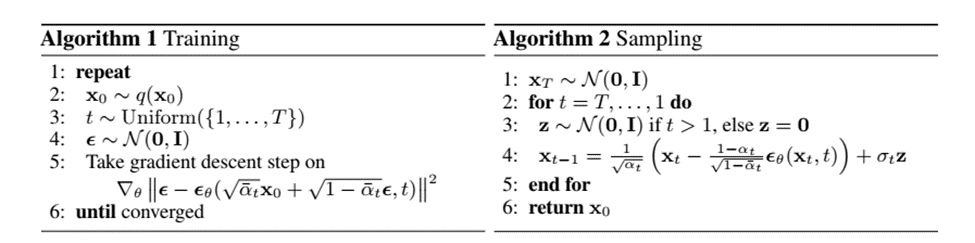

A crucial aspect of image generation is conditioning the sampling process to manipulate the generated samples. To turn a diffusion model 𝑝𝜃 into a conditional diffusion model, we can add conditioning information 𝑦 at each diffusion step.

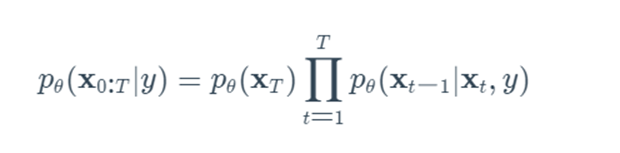

Sohl-Dickstein et al. and later Dhariwal and Nichol showed that we can use a second model, a classifier, to guide the diffusion toward the target class during training. To achieve that, we can train a classifier on the noisy image to predict its class. Then we can use the gradients to guide the diffusion.

In the famous GLIDE paper by Nichol et al, the authors expanded on this idea and use CLIP embeddings to guide the diffusion. CLIP as proposed by Saharia et al., consists of an image encoder 𝑔 and a text encoder ℎ. It produces an image and text embeddings 𝑔(𝑥𝑡) and ℎ(𝑐), respectively, wherein 𝑐 is the text caption.

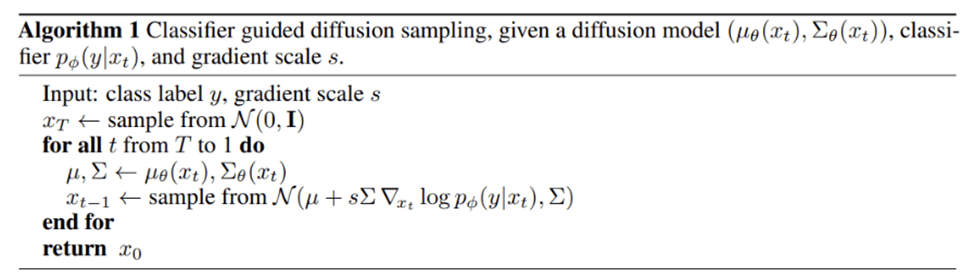


Guidance can be achieved without a second classifier model as proposed by Ho & Salimans. Instead of training a separate classifier, the authors trained a conditional diffusion model 𝜖𝜃(𝑥𝑡∣𝑦) together with an unconditional model 𝜖𝜃(𝑥𝑡∣0)ϵ. In fact, they use the exact same neural network. During training, they randomly set the class 𝑦 to 0, so that the model is exposed to both the conditional and unconditional setup.

In [ ]:
pipe.scheduler.compatibles

# The Scheduler

A scheduler takes a model’s output (the sample which the diffusion process is iterating on) and a timestep to return a denoised sample. The timestep is important because it dictates where in the diffusion process the step is; data is generated by iterating forward n timesteps and inference occurs by propagating backward through the timesteps. Based on the timestep, a scheduler may be discrete in which case the timestep is an int or continuous in which case the timestep is a float.

Depending on the context, a scheduler defines how to iteratively add noise to an image or how to update a sample based on a model’s output:


*   during training, a scheduler adds noise (there are different algorithms for how to add noise) to a sample to train a diffusion model
*   during inference, a scheduler defines how to update a sample based on a pretrained model’s output


LMSDiscreteScheduler uses a "linear multistep" method, meaning it looks at multiple previous steps to decide the next step, potentially making it more accurate or efficient. It’s designed for discrete beta schedules, which means it works with fixed time steps and a specific noise schedule.

# Variational Autoencoder (VAE)

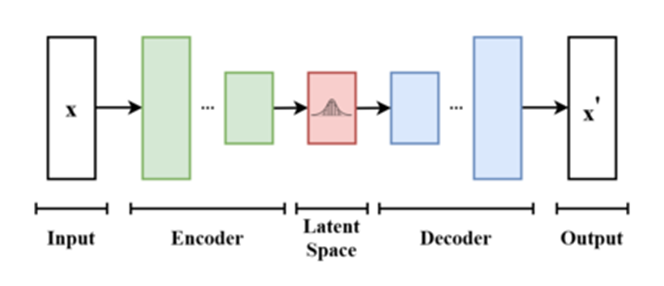

In machine learning, dimensionality reduction is the process of reducing the number of features that describe some data. This reduction is done either by selection (only some existing features are conserved) or by extraction (a reduced number of new features are created based on the old features) and can be useful in many situations that require low dimensional data (data visualization, data storage, heavy computation…).
The encoder is responsible for representing the input in a lower dimension (Latent Space). The Decoder is responsible for taking back the data to its original dimension. Normal autoencoder tries to push data points as far from each other as possible. Because of this, random samples from latent space don’t create valid images and you cannot create new images from the data.

Variational Autoencoders (VAEs) represent a significant advancement in generative modeling within machine learning, introduced by Diederik P. Kingma and Max Welling in 2013. They extend the concept of traditional autoencoders by incorporating probabilistic methods, enabling not only data compression and reconstruction but also the generation of new data samples that resemble the training set. This makes VAEs particularly useful for applications such as image synthesis, data augmentation, and anomaly detection.

To understand VAEs, it is essential first to grasp regular autoencoders. A regular autoencoder consists of an encoder that maps input data to a lower-dimensional latent space and a decoder that reconstructs the input from this space, aiming to minimize reconstruction error, typically measured by mean squared error or binary cross-entropy. The latent space in a regular autoencoder is deterministic, meaning each input maps to a single point, making it suitable for tasks like dimensionality reduction and feature learning but less effective for generating new data.

In contrast, VAEs introduce a probabilistic approach. The encoder outputs parameters (mean and variance) of a probability distribution, often assumed to be Gaussian, over the latent space, rather than a single value. This allows for sampling from the distribution to obtain latent variables, enabling the generation of new data points. This probabilistic encoding is a key differentiator, as it facilitates generative capabilities, making VAEs ideal for tasks requiring the creation of novel data, such as generating images of faces or digits.

Reconstruction Loss: This term measures how well the decoder reconstructs the input from the latent space. For continuous data, it is often the mean squared error (MSE)

KL Divergence Loss: This term measures the divergence between the approximate posterior q(z∣x) and the prior distribution p(z), typically a standard normal distribution N(0,I). For Gaussian distributions with diagonal covariance, it is computed as:

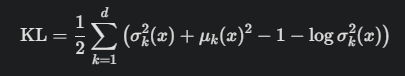

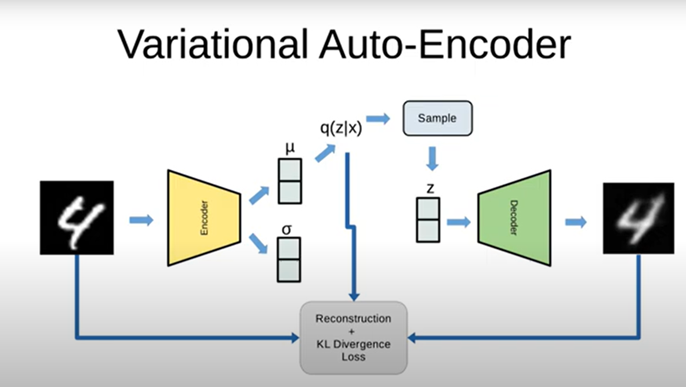

**Prior and Posterior in KL Divergence**
* Prior p(z): The prior distribution, typically a standard normal distribution N(0,I), represents the assumed distribution of the latent variables z before observing any data.
* Posterior p(z∣x): The true posterior distribution of z given the input x, which is the distribution we aim to approximate but cannot compute directly due to the intractability of the marginal likelihood p(x).
* Approximate Posterior q(z∣x): Learned by the encoder, this is a Gaussian distribution parameterized by mean and variance, designed to approximate p(z∣x).
* KL Divergence: In the loss function, it is KL(q(z∣x)∣∣p(z)), measuring the divergence between the approximate posterior and the prior. This ensures q(z∣x) remains close to p(z), aiding in maintaining a structured latent space for generation.

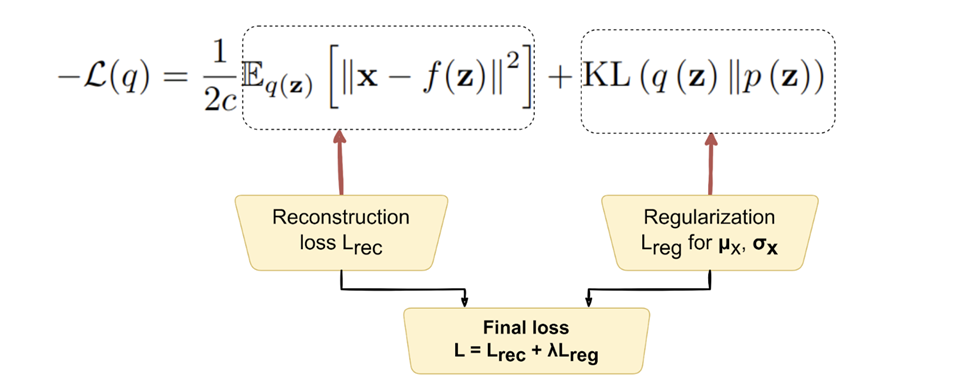

The reconstruction loss ensures that the VAE can represent the input data effectively, maintaining fidelity to the original dataset. Without it, the model might fail to learn meaningful representations, rendering it useless for both reconstruction and generation.

The KL divergence loss serves multiple purposes:

* Regularization:
It prevents overfitting by discouraging the encoder from learning highly specific, data-dependent representations, promoting generalization.
* Structured Latent Space:
By aligning q(z∣x) with a standard normal distribution, it ensures the latent space is continuous and smooth, facilitating interpolation between data points. This is essential for generating new data, as sampling from a well-structured space yields coherent outputs.
* Generative Ease:
It allows new data points to be generated by simply sampling from the prior distribution, making the generative process computationally efficient and intuitive.

|Feature|Regular Autoencoder|Variational Autoencoder (VAE)|
|-------|-------------------|-----------------------------|
Encoding Type|Deterministic (single point)|Probabilistic (distribution)|
Latent Space|Fixed, may be discontinuous|Continuous, normally distributed|
Primary Use|Compression, feature learning|Generative modeling, data generation|
Loss Function|Reconstruction error (e.g., MSE)|Reconstruction + KL divergence|
Generative Capability|Limited, mainly for reconstruction|High, can generate new data points|

# CLIP

CLIP is a pre-trained model for telling you how well a given image and a given text caption fit together, introduced by the paper “Learning Transferrable Visual Models from Natural Language Supervision” (2021) from OpenAI. It was trained contrastively on a huge amount (400 million) of web scraped data of image-caption pairs.

During training, the model requires that a huge batch of image-text pairs is fed at once (e.g., 20,000 pairs). That way, each batch contains 20,000*20,000 = 400,000,000 possible pairs, with only 20,000 being correct pairs. For efficient processing, the similarity scores of all possible pairs are computed at once to yield a 20,000 by 20,000 matrix, with the values in the diagonal being the similarity scores for the correct image-text pairs. That way, the objective function can have the goal to maximize the scores in the diagonal and minimize all the scores not in the diagonal.


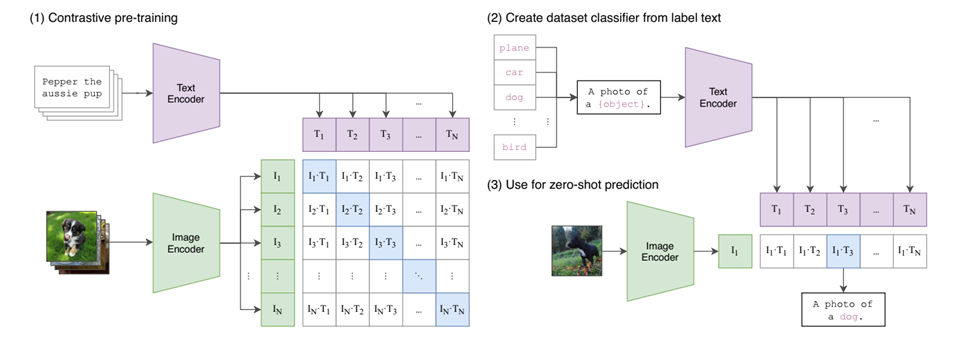

pip install git+https://github.com/openai/CLIP.git

In [ ]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

image = clip_preprocess(Image.open("cat.jpg")).unsqueeze(0).to(device)
titles = ["a diagram", "a dog", "a cat"]
text = clip.tokenize(titles).to(device)

with torch.no_grad():
    image_features = clip_model.encode_image(image)
    text_features = clip_model.encode_text(text)

    logits_per_image, logits_per_text = clip_model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)
print(f'The image is best represented by the text: {titles[torch.argmax(logits_per_image.softmax(dim=-1))]}')

In [ ]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image_index = 3691  # random index of an image 0-9999
image, class_id = cifar100[image_index]
true_class = cifar100.classes[class_id]  # Get the true class name

# Create a copy of the original image before preprocessing (for visualization)
original_image = image

# Preprocess image for CLIP
image_input = clip_preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = clip_model.encode_image(image_input)
    text_features = clip_model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Create a figure with two subplots: one for the image and one for the predictions
plt.figure(figsize=(12, 6))

# Plot the image on the left
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title(f"CIFAR100 Image #{image_index}\nTrue class: {true_class}")
plt.axis('off')

# Plot the predictions on the right
plt.subplot(1, 2, 2)
# Create a horizontal bar chart
classes = [cifar100.classes[idx] for idx in indices]
percentages = [100 * val.item() for val in values]
y_pos = range(len(classes))

# Reverse the order to have highest prediction at the top
classes.reverse()
percentages.reverse()

bars = plt.barh(y_pos, percentages, align='center')
plt.yticks(y_pos, classes)
plt.xlabel('Confidence (%)')
plt.title('Top 5 CLIP Predictions')

# Add percentage labels to the bars
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{percentages[i]:.2f}%', va='center')

# Highlight the correct class if it's in the top 5
if true_class in classes:
    idx = classes.index(true_class)
    bars[idx].set_color('green')

plt.tight_layout()
plt.savefig('clip_prediction.png')  # Save the visualization to a file
plt.show()

# Also print the result to console
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

# Unet

As shown earlier, the developers of Stable Diffusion used a UNET architecture to create the model. U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg.

In the original Unet, the layers are consist of convolutional layers with skip connections and either downsampling or upsampling, depending on which side of the network you are. But in Stable diffusion, the authors have included transformers and attention blocks as well.

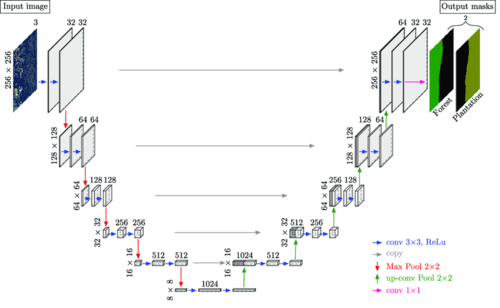

# Text to Image steps

In [ ]:
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)
# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)
# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [ ]:
# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

In [ ]:
prompt = ["A dragon fighting an angle in a demonic wasteland"] # the prompt to condition the diffusion process
# we use the tokenizer from CLIP to tokenize the prompt
#input_ids: representation of each token in the dictionary
#attention_mask: telling the model which words are part of prompt and which are just padding and should be ignored
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

In [ ]:
text_input

In [ ]:
# using the CLIP encoder to transform the prompt (after being tokenized) and get the embeddings

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))

In [ ]:
text_embeddings[0].shape

In [ ]:
# CLIP accepts maximum of 77 tokens
max_length = text_input.input_ids.shape[-1]
max_length

In [ ]:
# the number of input channels for the UNET
unet.config.in_channels

In [ ]:
batch_size = 1
height = 512 # final image hight
width = 768 # Final image width
generator = torch.manual_seed(4) # random seed

# creating a random noisy image as a starting point
latents = torch.randn(
(batch_size, unet.config.in_channels, height // 8, width // 8),
generator=generator,
)
latents.shape

In [ ]:
scheduler.set_timesteps(50)
scheduler.sigmas[0]

In [ ]:
vae.config.scaling_factor

# Stable Diffusion Manual Pipeline for Text to Image generation

In [ ]:
prompt = ["A dystopian city with skylines and flying cars"]
height = 512 # image hight
width = 768 # image width
num_inference_steps = 50 # number of diffusion steps
guidance_scale = 7.5 # controls how much the guidance impacts the image generation
generator = torch.manual_seed(420) # random seed
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = torch.randn(
(batch_size, unet.config.in_channels, height // 8, width // 8),
generator=generator,
)

latents = latents.to(torch_device)
# scale the initial noise by the standard deviation required by the scheduler
latents = latents * scheduler.sigmas[0]

    # Loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]

        # In the case of LMSDesc scheduler:
        # Scales the denoising model input by `(sigma**2 + 1) ** 0.5` to match the K-LMS algorithm.
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]


        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)


        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        # print(noise_pred.shape)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents)["prev_sample"]
        # print(t)

# scale and decode the image latents with vae
# We introduced the scale factor in the latent diffusion paper.
# The goal was to handle different latent spaces (from different autoencoders, which can be scaled quite differently than images)
# with similar noise schedules. The scale_factor
# ensures that the initial latent space on which the diffusion model is operating has approximately unit variance.
latents = latents / vae.config.scaling_factor

with torch.no_grad():
    image = vae.decode(latents)

# print(image['sample'].shape)
image = image['sample']
# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

# Stable Diffusion 3

Esser, P., Kulal, S., Blattmann, A., Entezari, R., Müller, J., Saini, H., Levi, Y., Lorenz, D., Sauer, A., Boesel, F., Podell, D., Dockhorn, T., English, Z., Lacey, K., Goodwin, A., Marek, Y. and Rombach, R. (2024). Scaling Rectified Flow Transformers for High-Resolution Image Synthesis. arXiv (Cornell University). doi:https://doi.org/10.48550/arxiv.2403.03206.

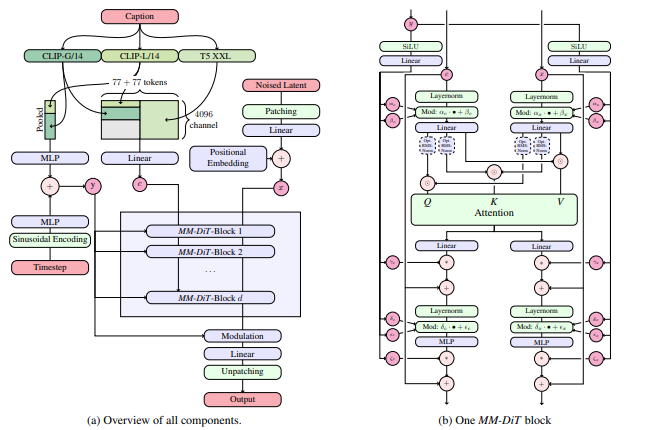

Rectified Flow:
Liu, X., Gong, C. and Liu, Q. (2022). Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow. arXiv (Cornell University). doi:https://doi.org/10.48550/arxiv.2209.03003.

SD3 uses three text encoders, one of which is the very large T5-XXL model. This makes it challenging to run the model on GPUs with less than 24GB of VRAM, even when using fp16 precision. The following section outlines a few memory optimizations in Diffusers that make it easier to run SD3 on low resource hardware.
The most basic memory optimization available in Diffusers allows you to offload the components of the model to CPU during inference in order to save memory, while seeing a slight increase in inference latency. Model offloading will only move a model component onto the GPU when it needs to be executed, while keeping the remaining components on the CPU.

In [ ]:
import torch
from diffusers import StableDiffusion3Pipeline

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
pipe.enable_model_cpu_offload()

image = pipe(
    prompt="a photo of a cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    height=1024,
    width=1024,
    guidance_scale=7.0,
).images[0]

image.save("sd3_hello_world.png")


Removing the memory-intensive 4.7B parameter T5-XXL text encoder during inference can significantly decrease the memory requirements for SD3 with only a slight loss in performance.

In [ ]:
import torch
from diffusers import StableDiffusion3Pipeline

pipe = StableDiffusion3Pipeline.from_pretrained(
    "stabilityai/stable-diffusion-3-medium-diffusers",
    text_encoder_3=None,
    tokenizer_3=None,
    torch_dtype=torch.float16
)
pipe.to("cuda")

image = pipe(
    prompt="a photo of a cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    height=1024,
    width=1024,
    guidance_scale=7.0,
).images[0]

image.save("sd3_hello_world-no-T5.png")